<a href="https://colab.research.google.com/github/spqr-86/notebooks/blob/main/movies_by_genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
    <img src="https://myastudios.com/wp-content/uploads/2020/10/imdb-button-e1601534620124.png" alt="cognitiveclass.ai logo">
</center>
<h1 align=center><font size = 5>IMDB horror movies analysis</font></h1>

## Understand the datasets

The IMDb Movies Dataset is a comprehensive collection of movies listed on IMDb, sorted by genre. 

A detailed description of this dataset and the original dataset can be obtained from the Kaggle at:
https://www.kaggle.com/datasets/rajugc/imdb-movies-dataset-based-on-genre

### Download the datasets

In [ ]:
import pandas as pd
url = '/content/drive/MyDrive/Dataframes/imbd_archive/horror.csv'
df = pd.read_csv(url)
df.head()

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt15679400,Knock at the Cabin,2023,R,100 min,"Horror, Mystery, Thriller",6.4,"While vacationing, a girl and her parents are ...",M. Night Shyamalan,/name/nm0796117/,"Dave Bautista, \nJonathan Groff, \nRupert Grin...","/name/nm1176985/,/name/nm2676147/,/name/nm0342...",17991.0,NaN
1,tt9764362,The Menu,2022,R,107 min,"Horror, Thriller",7.2,A young couple travels to a remote island to e...,Mark Mylod,/name/nm0617042/,"Ralph Fiennes, \nAnya Taylor-Joy, \nNicholas H...","/name/nm0000146/,/name/nm5896355/,/name/nm0396...",232052.0,NaN
2,tt8760708,M3GAN,2022,PG-13,102 min,"Horror, Sci-Fi, Thriller",6.4,A robotics engineer at a toy company builds a ...,Gerard Johnstone,/name/nm2067421/,"Allison Williams, \nViolet McGraw, \nRonny Chi...","/name/nm4129745/,/name/nm8627157/,/name/nm5307...",62458.0,NaN
3,tt13051810,Viking Wolf,2022,TV-MA,97 min,"Horror, Thriller",5.1,Thale (17) has just moved with her parents to ...,Stig Svendsen,/name/nm1457169/,"Liv Mjönes, \nElli Rhiannon Müller Osborne, \n...","/name/nm1203571/,/name/nm9602953/,/name/nm7416...",3872.0,NaN
4,tt10365998,Infinity Pool,2023,R,117 min,"Crime, Horror, Mystery",6.5,James and Em Foster are enjoying an all-inclus...,Brandon Cronenberg,/name/nm0188722/,"Alexander Skarsgård, \nMia Goth, \nCleopatra C...","/name/nm0002907/,/name/nm5301405/,/name/nm1671...",6955.0,NaN


### Store the datasets in database tables


In [ ]:
# enables the use of SQL statements directly in the notebook cells.
%load_ext sql

In [ ]:
import sqlite3
# Create a connection to the database.
con = sqlite3.connect("movies.db")
# Get a cursor for executing SQL statements.
cur = con.cursor()

In [ ]:
%sql sqlite:///movies.db

'Connected: @movies.db'

In [ ]:
# calculate the percentage of missing values.
per_missing = df.isnull().sum()*100/len(df)
per_missing

movie_id        0.000000
movie_name      0.000000
year           20.694073
certificate    73.428384
runtime        36.312088
genre           0.000000
rating         42.317758
description     0.000000
director        8.355597
director_id     8.355597
star           19.437326
star_id        17.321847
votes          42.317758
gross(in $)    96.330625
dtype: float64

In [ ]:
# Delete rows where there are no values ​​in the columns "director", "rating", "star".
df = df.dropna(subset=['rating', 'director', 'star'])

In [ ]:
# Creating the genres table
con.execute('''CREATE TABLE IF NOT EXISTS genres
               (genre_id integer PRIMARY KEY AUTOINCREMENT, 
                genre_name text)''')

# Creating the actors table
con.execute('''CREATE TABLE IF NOT EXISTS actors
               (actor_id TEXT PRIMARY KEY,
                name TEXT)''')

# Creating the directors table
con.execute('''CREATE TABLE IF NOT EXISTS directors
               (director_id TEXT PRIMARY KEY,
                name TEXT)''')

# Creating the movies table
con.execute('''CREATE TABLE IF NOT EXISTS movies
               (movie_id text PRIMARY KEY, movie_name text, year int, 
                certificate text, runtime text, rating float, description text,
                num_votes int, gross float,
                director_id text,
                FOREIGN KEY (director_id) REFERENCES directors(directorid))''')

# Creating the movie_genre table
con.execute('''CREATE TABLE IF NOT EXISTS movie_genre
             (movie_id text, genre_id integer,
              FOREIGN KEY(movie_id) REFERENCES movies(movie_id),
              FOREIGN KEY(genre_id) REFERENCES genres(genre_id))''')

# Creating the movie_actor table
con.execute('''CREATE TABLE IF NOT EXISTS movie_actor
             (movie_id text, actor_id text,
              FOREIGN KEY(movie_id) REFERENCES movies(movie_id),
              FOREIGN KEY(actor_id) REFERENCES actors(actor_id))''')

# Creating sets to store unique actors and directors
actors = set()
directors = set()

# Creating a dictionary with the mapping of genres and their ids
genres_dict = {}

line_number = 1

# Processing each row 
for index, row in df.iterrows():
    genre_names = row['genre'].split(', ')
    movie_id = row['movie_id']

    # Inserting genres
    for genre in genre_names:
        if genre not in genres_dict:
            genre_id = line_number
            con.execute('''INSERT INTO genres (genre_id, genre_name) 
                           VALUES (?, ?)''', (genre_id, genre))
            con.execute('''INSERT INTO movie_genre (movie_id, genre_id) 
                           VALUES (?, ?)''', (movie_id, genre_id))
            genres_dict[genre] = genre_id
            line_number += 1
        else:
          genre_id = genres_dict[genre]
          con.execute('''INSERT INTO movie_genre (movie_id, genre_id) 
                         VALUES (?, ?)''', (movie_id, genre_id))
    
    star_names = row['star'].split(', \n')
    star_ids = row['star_id'].split(',')

    # Inserting actors
    for i in range(len(star_names)):
        actor = (star_ids[i].strip(), star_names[i].strip())
        con.execute('''INSERT INTO movie_actor (movie_id, actor_id) 
                       VALUES (?, ?)''', (movie_id, actor[0]))
        if actor not in actors:
            con.execute(
                '''INSERT OR IGNORE INTO actors (actor_id, name) 
                   VALUES (?, ?)''', (actor[0], actor[1]))
        actors.add(actor)
    # Inserting directors
    director_name = row['director']
    director_id = row['director_id']
    director = (director_id.strip(), director_name.strip())
    if director not in directors:
      con.execute(
          "INSERT OR IGNORE INTO directors (director_id, name) VALUES (?, ?)", 
          (director[0], director[1]))   
    directors.add(director)

    # Inserting movies
    con.execute('''INSERT INTO movies
                 (movie_id, movie_name, year, certificate, runtime, rating, 
                  description, num_votes, gross, director_id)
                  VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                (row['movie_id'], row['movie_name'], row['year'], 
                 row['certificate'], row['runtime'], row['rating'], 
                 row['description'], row['votes'], row['gross(in $)'], 
                 row['director_id']))
con.commit()

## Problems




### Average rating of all movies


In [ ]:
avg_rating = %sql SELECT AVG(rating) FROM movies;
avg_rating

 * sqlite:///movies.db
Done.


AVG(rating)
5.007855028173049


### Weighted_ratings view

The formula for the weighted rating is as follows:

(WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

where:

R = the mean rating for the movie

v = the number of votes for the movie

m = the minimum number of votes required for the movie to 
be considered in the Top 250 rankings (currently 25,000)

C = the mean vote across the whole report



In [ ]:
# creating a view called "weighted_ratings"
%sql CREATE VIEW weighted_ratings AS \
     SELECT movie_id,                \
            ROUND((num_votes/(num_votes + 25000.0))*rating+(25000.0/(num_votes+25000.0))*5, 2) weighted_rating \
       FROM movies;

 * sqlite:///movies.db
Done.


[]

### The top 10 horror movies by weighted rating



In [ ]:
%sql SELECT mv.movie_name, wr.weighted_rating, mv.year, dr.name, mv.gross \
     FROM movies mv                                                       \
     LEFT JOIN weighted_ratings wr ON mv.movie_id = wr.movie_id           \
     LEFT JOIN directors dr ON mv.director_id = dr.director_id            \
     ORDER BY 2 DESC                                                      \
     LIMIT 10; 

 * sqlite:///movies.db
Done.


movie_name,weighted_rating,year,name,gross
Alien,8.4,1979,Ridley Scott,78900000.0
Psycho,8.38,1960,Alfred Hitchcock,32000000.0
The Shining,8.32,1980,Stanley Kubrick,44017374.0
The Thing,8.02,1982,John Carpenter,13782838.0
The Exorcist,7.92,1973,William Friedkin,232906145.0
Shaun of the Dead,7.78,2004,Edgar Wright,13542874.0
Rosemary's Baby,7.69,1968,Roman Polanski,None
Predator,7.65,1987,John McTiernan,59735548.0
Get Out,7.6,2017,Jordan Peele,176040665.0
Let the Right One In,7.6,2008,Tomas Alfredson,2122065.0


### The top 10 directors by weighted assessment who have shot more than 2 films



In [ ]:
%sql SELECT dr.name,                                               \
            ROUND(AVG(wr.weighted_rating), 2) WR,                  \
            COUNT(*) AS movie_count                                \
       FROM movies mv                                              \
       LEFT JOIN directors dr ON mv.director_id = dr.director_id   \
       LEFT JOIN weighted_ratings wr ON mv.movie_id = wr.movie_id  \
      GROUP BY 1                                                   \
     HAVING COUNT(*) > 2                                           \
      ORDER BY 2 DESC                                              \
      LIMIT 20;

 * sqlite:///movies.db
Done.


name,WR,movie_count
Jordan Peele,6.98,3
Roman Polanski,6.89,3
Tim Burton,6.74,4
Peter Jackson,6.54,3
James Whale,6.54,4
Andy Muschietti,6.54,3
Robert Rodriguez,6.49,5
David Lynch,6.49,3
James Wan,6.47,8
Alejandro Amenábar,6.43,3


### Actor with the most horror movies

In [ ]:
%sql SELECT ac.name, COUNT(*)                                \
       FROM movies mv                                        \
       JOIN movie_actor mvac ON mv.movie_id = mvac.movie_id  \
       JOIN actors ac ON mvac.actor_id = ac.actor_id         \
      GROUP BY 1                                             \
      ORDER BY 2 DESC                                        \
      LIMIT 1;

 * sqlite:///movies.db
Done.


name,COUNT(*)
Christopher Lee,64


### Average Gross Revenue per Year

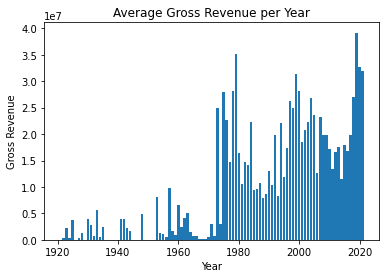

In [ ]:
import matplotlib.pyplot as plt

query = """SELECT mv.year AS release_year, 
                  ROUND(AVG(mv.gross), 2) AS gross 
             FROM movies mv 
            GROUP BY release_year 
            ORDER BY release_year DESC;"""
df = pd.read_sql_query(query, con)
df.dropna(inplace=True)

# create bar chart using matplotlib
plt.bar(df['release_year'], df['gross'])
plt.title('Average Gross Revenue per Year')
plt.xlabel('Year')
plt.ylabel('Gross Revenue')
plt.show()